# Image Fill by Direct Convolution

Let's start with a very simple and direct way for the image filling. The input data is a four channel incompleted image with a fourth channel indicating the missing part of the image.

A four-layer Convolution Nueral Network model is built here. Each layer has 64 channels with a 5x5 kernel size. The final result will be a filled-in 3-channel image.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import tensorflow as tf
import math
from sklearn import model_selection
import keras

from keras import layers
from keras import models
from keras import Model
from keras.datasets import mnist
from keras import backend as K
from keras import metrics
from keras import optimizers

K.tensorflow_backend._get_available_gpus()

# The Function used to plot the original image and the predicted image 
def Plot_Img(n,images,fig_w,fig_h):
    # n is how many digits we will display//
    plt.figure(figsize=(fig_w, fig_h))
    for i in range(n):
        # display images
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
    
# The Function used to remove the middle square of the image
def Img_incomp(imgs,start=8,end=22):
    n = imgs.shape[0]
    for i in range(n):
        imgs[i][start:end,start:end,:] = 0
    return imgs

batch_size = 50
height = 32
width = 32
channels = 3

Using TensorFlow backend.


Data preparation. I use the CIFAR10 dataset here and pick all the car images.

In [0]:
(x_train,y_train),(x_test,y_test) = keras.datasets.cifar10.load_data()
x_train = x_train[y_train.flatten() == 1]
x_test = x_test[y_test.flatten() == 1]

# Normalize the pixels to 0 and 1 range
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

(x_tra,y_tra),(x_te,y_te) = keras.datasets.cifar10.load_data()
x_tra = x_tra[y_tra.flatten() == 1]
x_te = x_te[y_te.flatten() == 1]

# Normalize the pixels to 0 and 1 range
x_tra = x_tra.astype('float32') / 255.
x_te = x_te.astype('float32') / 255.

170500096/170498071 [==============================] - 27s 0us/step


Show an example of incomplete images.

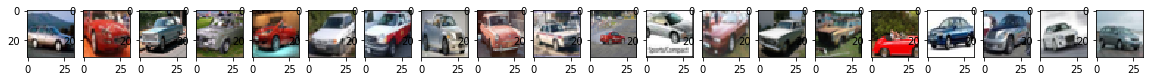

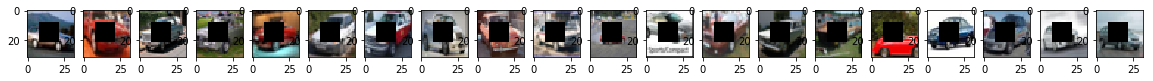

In [0]:
# Modfied training and testing imgs
x_train = Img_incomp(x_train)
x_test = Img_incomp(x_test)

# Plot some examples
Plot_Img(20,x_tra,20,10)
Plot_Img(20,x_train,20,10)
plt.show()

Set up the matrices indicating the incomplete part of the images

In [0]:
# Incomplete part matrices
cond_train = np.ones((x_train.shape[0],32,32,1))
cond_test = np.ones((x_test.shape[0],32,32,1))
cond_train = Img_incomp(cond_train)
cond_test = Img_incomp(cond_test)
print (cond_train.shape)
print (cond_test.shape)

(5000, 32, 32, 1)
(1000, 32, 32, 1)


Build up the CNN model

In [0]:
input1 = layers.Input(batch_shape=(batch_size,height,width,channels))
input2 = layers.Input(batch_shape=(batch_size,height,width,1))
inpt = layers.concatenate([input1,input2], axis=-1)

# Layer1
l1 = layers.Conv2D(64,(5,5),activation='relu',padding='same')(inpt)
# Layer2
l2 = layers.Conv2D(64,(5,5),activation='relu',padding='same')(l1)
# Layer3
l3 = layers.Conv2D(64,(5,5),activation='relu',padding='same')(l2)
# Layer4
l4 = layers.Conv2D(64,(5,5),activation='relu',padding='same')(l3)

# Output
output = layers.Conv2D(3,(5,5),activation='sigmoid',padding='same')(l4)

convmodel = Model([input1,input2],output)
convmodel.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (50, 32, 32, 3)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (50, 32, 32, 1)      0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (50, 32, 32, 4)      0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (50, 

Model compile and train

In [0]:
convmodel_opt = optimizers.Adam(0.0005,0.5)
convmodel.compile(optimizer=convmodel_opt, loss='mean_squared_error')
convmodel.fit([x_train,cond_train],x_tra,epochs=50,batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
5000/5000 [==============================] - 5s 1ms/step - loss: 0.0219
Epoch 2/50
5000/5000 [==============================] - 2s 465us/step - loss: 0.0098
Epoch 3/50
5000/5000 [==============================] - 2s 468us/step - loss: 0.0075
Epoch 4/50
5000/5000 [==============================] - 2s 466us/step - loss: 0.0067
Epoch 5/50
5000/5000 [==============================] - 2s 467us/step - loss: 0.0060
Epoch 6/50
5000/5000 [==============================] - 2s 469us/step - loss: 0.0057
Epoch 7/50
5000/5000 [==============================] - 2s 466us/step - loss: 0.0054
Epoch 8/50
5000/5000 [==============================] - 2s 471us/step - loss: 0.0052
Epoch 9/50
5000/5000 [==============================] - 2s 471us/step - loss: 0.0049
Epoch 10/50
5000/5000 [==============================] - 2s 472us/step - loss: 0.0048
Epoch 11/50
5000/5000 [==============================] - 2s 474us/step - loss: 0.0048
Epoch 12/50
5000/

Training data filled in

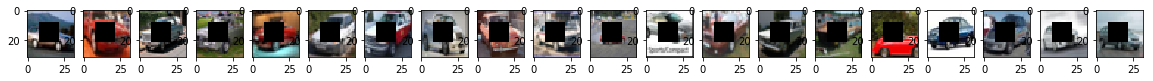

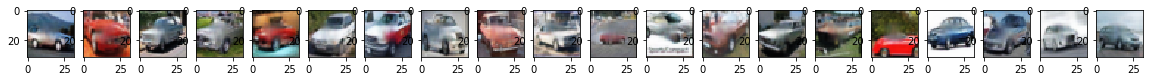

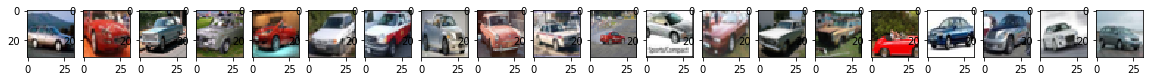

In [0]:
convmodel_recons = convmodel.predict([x_train,cond_train],batch_size=batch_size)
Plot_Img(20,x_train,20,10)
Plot_Img(20,convmodel_recons,20,10)
Plot_Img(20,x_tra,20,10)
plt.show()

Test data filled in

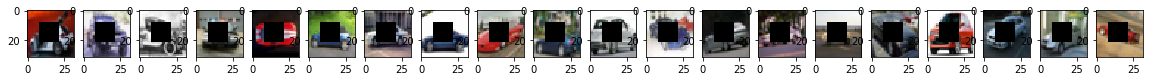

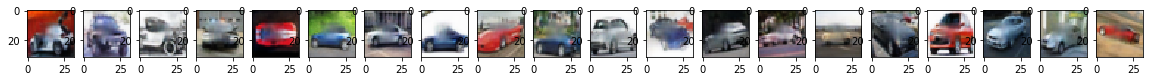

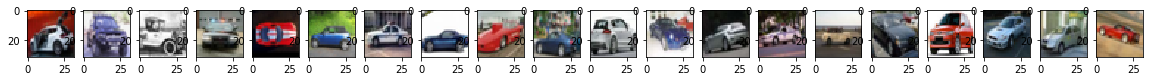

In [0]:
convmodel_recons_test = convmodel.predict([x_test,cond_test],batch_size=batch_size)
Plot_Img(20,x_test,20,10)
Plot_Img(20,convmodel_recons_test,20,10)
Plot_Img(20,x_te,20,10)
plt.show()

The new function used to put a random shadow to the training data

In [0]:
import random

# The Function used to remove the middle square of the image
def Img_incomp_rand(imgs,cond,w=12):
    n = imgs.shape[0]
    for i in range(n):
        start = random.randint(0,31-w)
        end = start+w
        imgs[i][start:end,start:end,:] = 0
        cond[i][start:end,start:end,:] = 0
    return imgs,cond

Show images with the new random masks

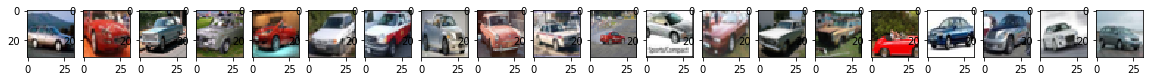

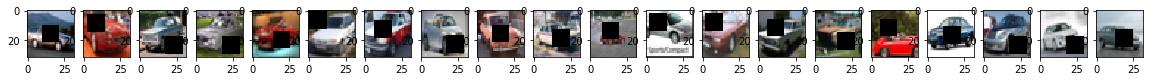

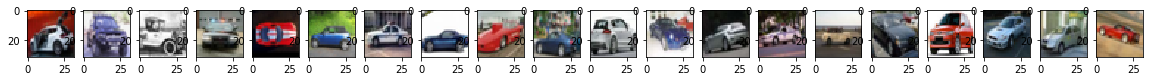

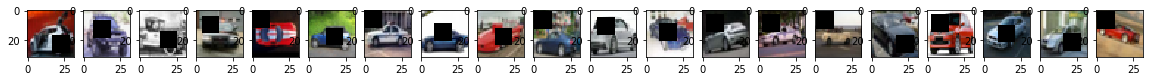

In [0]:
(x_train,y_train),(x_test,y_test) = keras.datasets.cifar10.load_data()
x_train = x_train[y_train.flatten() == 1]
x_test = x_test[y_test.flatten() == 1]

# Normalize the pixels to 0 and 1 range
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

cond_train = np.ones((x_train.shape[0],32,32,1))
cond_test = np.ones((x_test.shape[0],32,32,1))

x_train,cond_train = Img_incomp_rand(x_train,cond_train)
x_test,cond_test = Img_incomp_rand(x_test,cond_test)

# Training Images
Plot_Img(20,x_tra,20,10)
Plot_Img(20,x_train,20,10)
plt.show()

# Test Images
Plot_Img(20,x_te,20,10)
Plot_Img(20,x_test,20,10)
plt.show()

Train the data

In [0]:
convmodel.fit([x_train,cond_train],x_tra,epochs=100,batch_size=batch_size)

Epoch 1/100
5000/5000 [==============================] - 2s 480us/step - loss: 0.0035
Epoch 2/100
5000/5000 [==============================] - 2s 480us/step - loss: 0.0034
Epoch 3/100
5000/5000 [==============================] - 2s 479us/step - loss: 0.0035
Epoch 4/100
5000/5000 [==============================] - 2s 479us/step - loss: 0.0034
Epoch 5/100
5000/5000 [==============================] - 2s 482us/step - loss: 0.0035
Epoch 6/100
5000/5000 [==============================] - 2s 480us/step - loss: 0.0034
Epoch 7/100
5000/5000 [==============================] - 2s 480us/step - loss: 0.0034
Epoch 8/100
5000/5000 [==============================] - 2s 486us/step - loss: 0.0034
Epoch 9/100
5000/5000 [==============================] - 2s 486us/step - loss: 0.0034
Epoch 10/100
5000/5000 [==============================] - 2s 483us/step - loss: 0.0033
Epoch 11/100
5000/5000 [==============================] - 2s 485us/step - loss: 0.0034
Epoch 12/100
5000/5000 [============================

New data prediction results

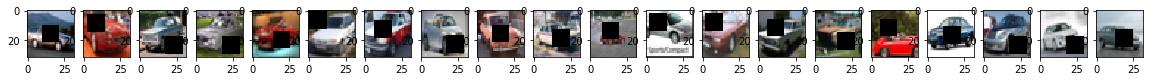

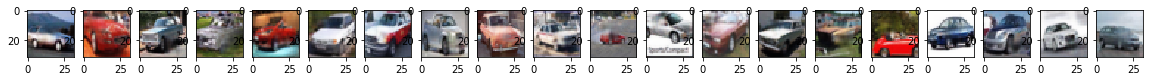

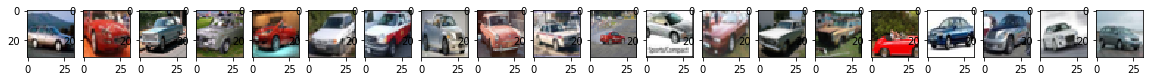

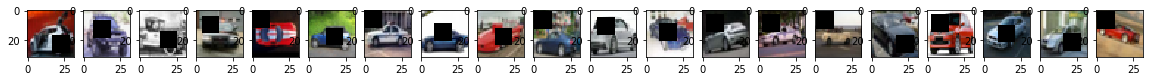

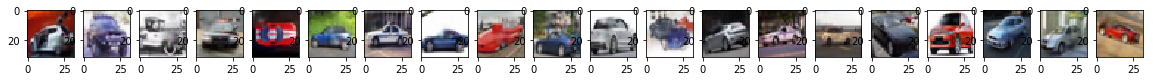

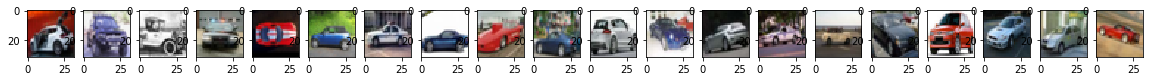

In [0]:
convmodel_recons = convmodel.predict([x_train,cond_train],batch_size=batch_size)
Plot_Img(20,x_train,20,10)
Plot_Img(20,convmodel_recons,20,10)
Plot_Img(20,x_tra,20,10)
plt.show()

convmodel_recons_test = convmodel.predict([x_test,cond_test],batch_size=batch_size)
Plot_Img(20,x_test,20,10)
Plot_Img(20,convmodel_recons_test,20,10)
Plot_Img(20,x_te,20,10)
plt.show()

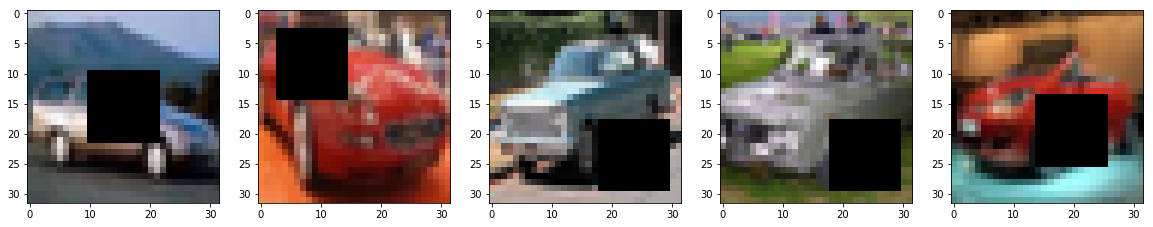

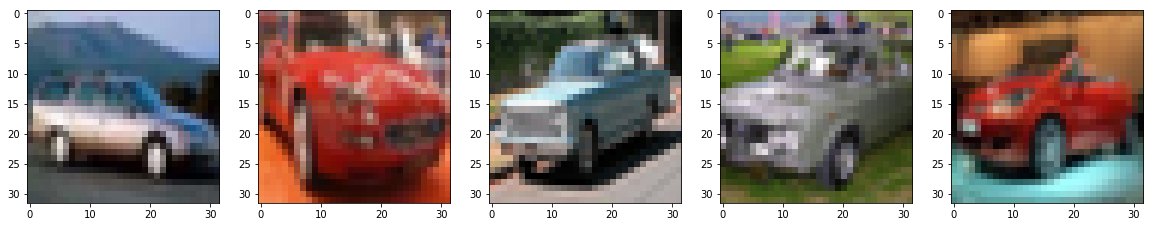

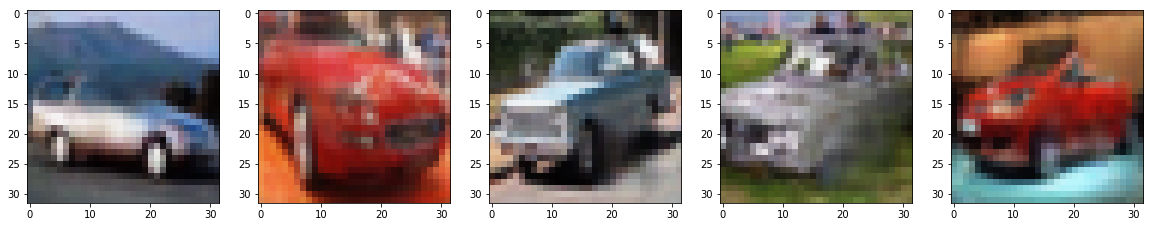

In [0]:
Plot_Img(5,x_train,20,10)
Plot_Img(5,x_tra,20,10)
Plot_Img(5,convmodel_recons,20,10)

In [0]:
sqerror = []
for i in range(1000):
  sqerror.append(np.sum((convmodel_recons_test[i]-x_te[i])**2))
sqerror = np.array(sqerror)

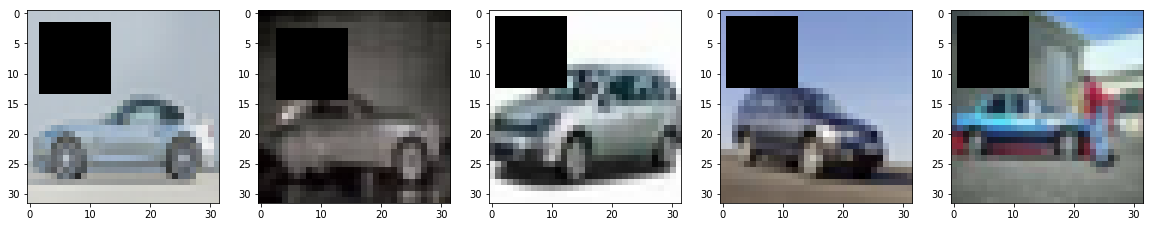

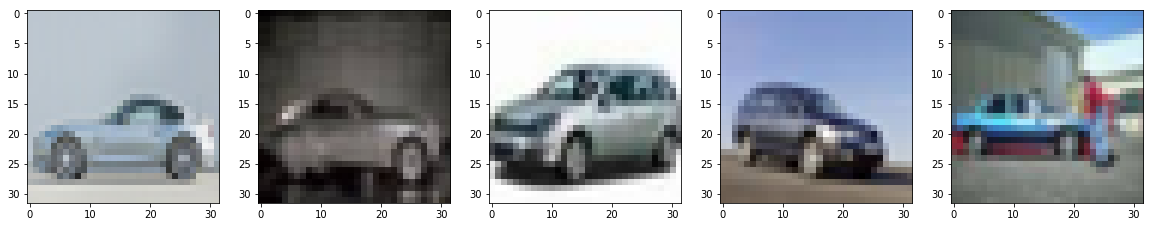

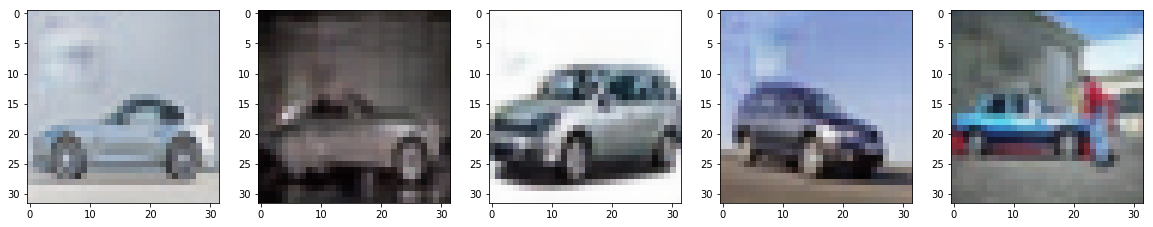

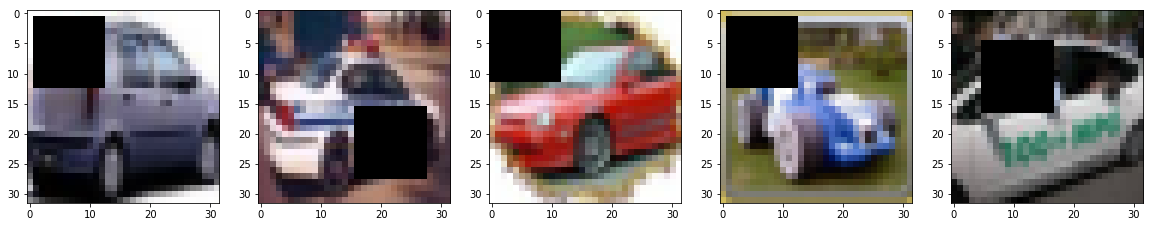

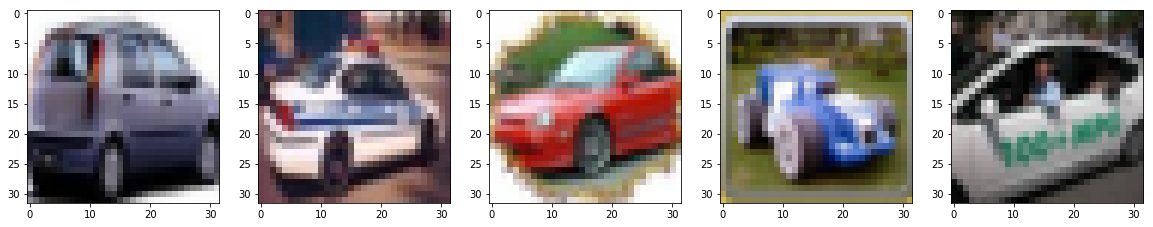

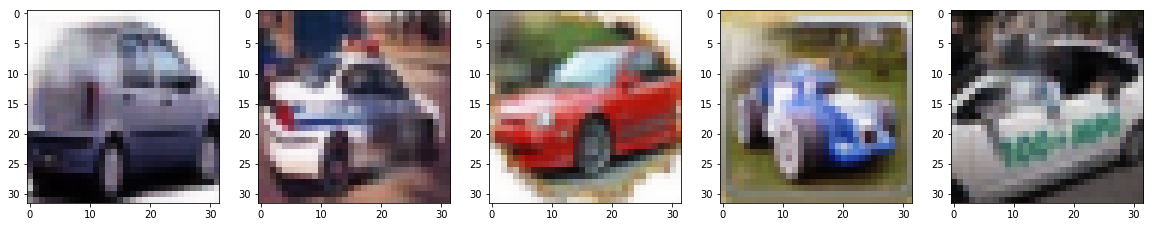

In [0]:
first_5 = np.argsort(sqerror)[0:5]
last_5 = np.argsort(sqerror)[995:1000]

Plot_Img(5,x_test[first_5],20,10)
Plot_Img(5,x_te[first_5],20,10)
Plot_Img(5,convmodel_recons_test[first_5],20,10)

Plot_Img(5,x_test[last_5],20,10)
Plot_Img(5,x_te[last_5],20,10)
Plot_Img(5,convmodel_recons_test[last_5],20,10)